In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
 
        # ==================================
        #  Parameters
        # ==================================
    
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

In [3]:
class Vehicle(Vehicle):
    def step(self, throttle, alpha):
        # ==================================
        #  Implement vehicle model here
        # ==================================
         # Throttle to engine torque parameters
        a_0 = self.a_0
        a_1 = self.a_1
        a_2 = self.a_2

        # Gear ratio, effective radius, mass + inertia
        G_R = self.GR
        r_eff = self.r_e
        J_e = self.J_e
        m = self.m
        g = self.g

        # Aerodynamic and friction coefficients
        c_a = self.c_a
        c_r = self.c_r1

        # Tire force parameters
        c_s = self.c
        F_max = self.F_max

        # Unpack state variables
        x_dot = self.v
        x = self.x
        omega_e = self.w_e
        
         # Compute engine torque
        T_e = throttle * (a_0 + a_1 * omega_e + a_2 * omega_e ** 2)

        # Compute load forces
        F_aero = 0.5 * c_a * x_dot ** 2
        R_x = c_r * x_dot
        F_g = m * g * np.sin(alpha)
        F_load = F_aero + R_x + F_g

        # Compute tire force
        s = ( r_eff * G_R * omega_e - x_dot) / x_dot
        if abs(s) < 1:
            F_x = c_s * s
        else:
            F_x = F_max

        # Compute acceleration
        x_dot_dot = (F_x - F_load)/m

        # Update state variables using numerical integration
        x_dot += x_dot_dot * self.sample_time
        x += x_dot * self.sample_time
        omega_e_dot = (T_e - G_R * r_eff * F_load)/J_e
        omega_e += omega_e_dot * sample_time

        # Update the state variables of the vehicle
        self.x = x
        self.v = x_dot
        self.a = x_dot_dot
        self.w_e = omega_e
        self.w_e_dot = omega_e_dot


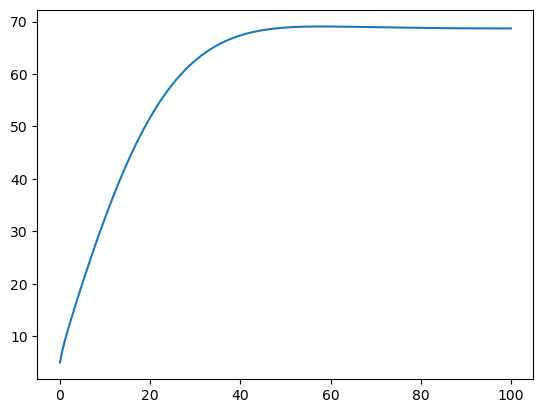

In [4]:
sample_time = 0.01
time_end = 100
model = Vehicle()

t_data = np.arange(0,time_end,sample_time)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 1

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.v
    model.step(throttle, alpha)
    
plt.plot(t_data, v_data)
plt.show()